In [30]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
API_KEY = 'b8e0905a9f30fed346916bd87ad51581'
CITY = 'São Paulo,BR'
URL = f'http://api.openweathermap.org/data/2.5/forecast?q={CITY}&appid={API_KEY}&units=metric'


In [7]:
def fetch_weather_data():
    response = requests.get(URL)
    data = response.json()
    return data

In [31]:
# Função para processar os dados e criar um DataFrame
def process_data(data):
    records = []
    for entry in data['list']:
        record = {
            'temperature': entry['main']['temp'],
            'humidity': entry['main']['humidity'],
            'pressure': entry['main']['pressure'],
            'wind_speed': entry['wind']['speed'],
            'clouds': entry['clouds']['all'],
            'rain': 1 if 'rain' in entry and '3h' in entry['rain'] else 0  # Choveu ou não
        }
        records.append(record)
    return pd.DataFrame(records)

In [32]:
# Coletar e processar os dados
weather_data = fetch_weather_data()
df = process_data(weather_data)

In [33]:
weather_data = fetch_weather_data()
df = process_data(weather_data)
display(df.head())


,temperature,humidity,pressure,wind_speed,clouds,rain
0,23.73,86,1011,2.94,72,1
1,22.14,94,1011,4.05,92,1
2,21.22,95,1012,2.71,100,1
3,20.75,96,1012,1.90,100,0
4,20.16,96,1010,1.89,97,0


In [35]:
# Análise descritiva
df.describe()

,temperature,humidity,pressure,wind_speed,clouds,rain
count,40.000000,40.000000,40.000000,40.00000,40.000000,40.000000
mean,21.647000,87.475000,1010.250000,2.77425,96.925000,0.550000
std,1.719235,7.500385,1.613246,1.16851,5.283683,0.503831
min,19.500000,64.000000,1007.000000,0.52000,72.000000,0.000000
25%,20.222500,84.000000,1009.000000,1.91500,96.000000,0.000000
50%,21.175000,89.000000,1010.000000,2.61500,99.000000,1.000000
75%,22.602500,93.000000,1011.000000,3.82000,100.000000,1.000000
max,26.430000,97.000000,1014.000000,5.06000,100.000000,1.000000


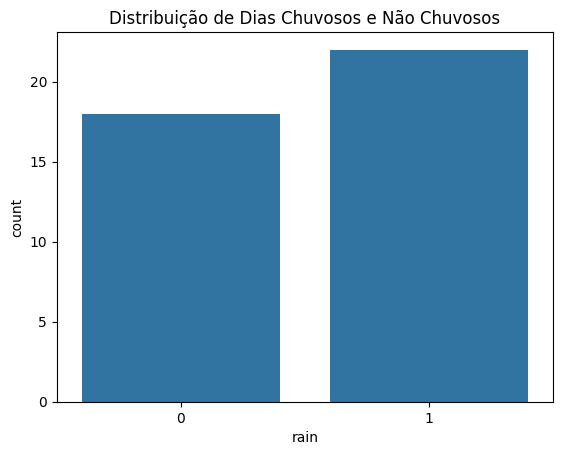

In [36]:
# Visualizar distribuição de chuva
sns.countplot(x=df['rain'])
plt.title('Distribuição de Dias Chuvosos e Não Chuvosos')
plt.show()

In [37]:
# Separar features e target
X = df.drop('rain', axis=1)
y = df['rain']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Treinar a Árvore de Classificação
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [41]:
# Fazer previsões
y_pred = tree.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy}')
print(classification_report(y_test, y_pred))

Acurácia: 0.875
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.75      0.86         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8



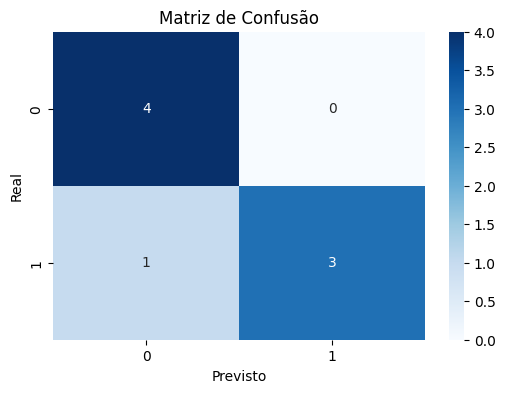

In [42]:
# Matriz de confusão
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

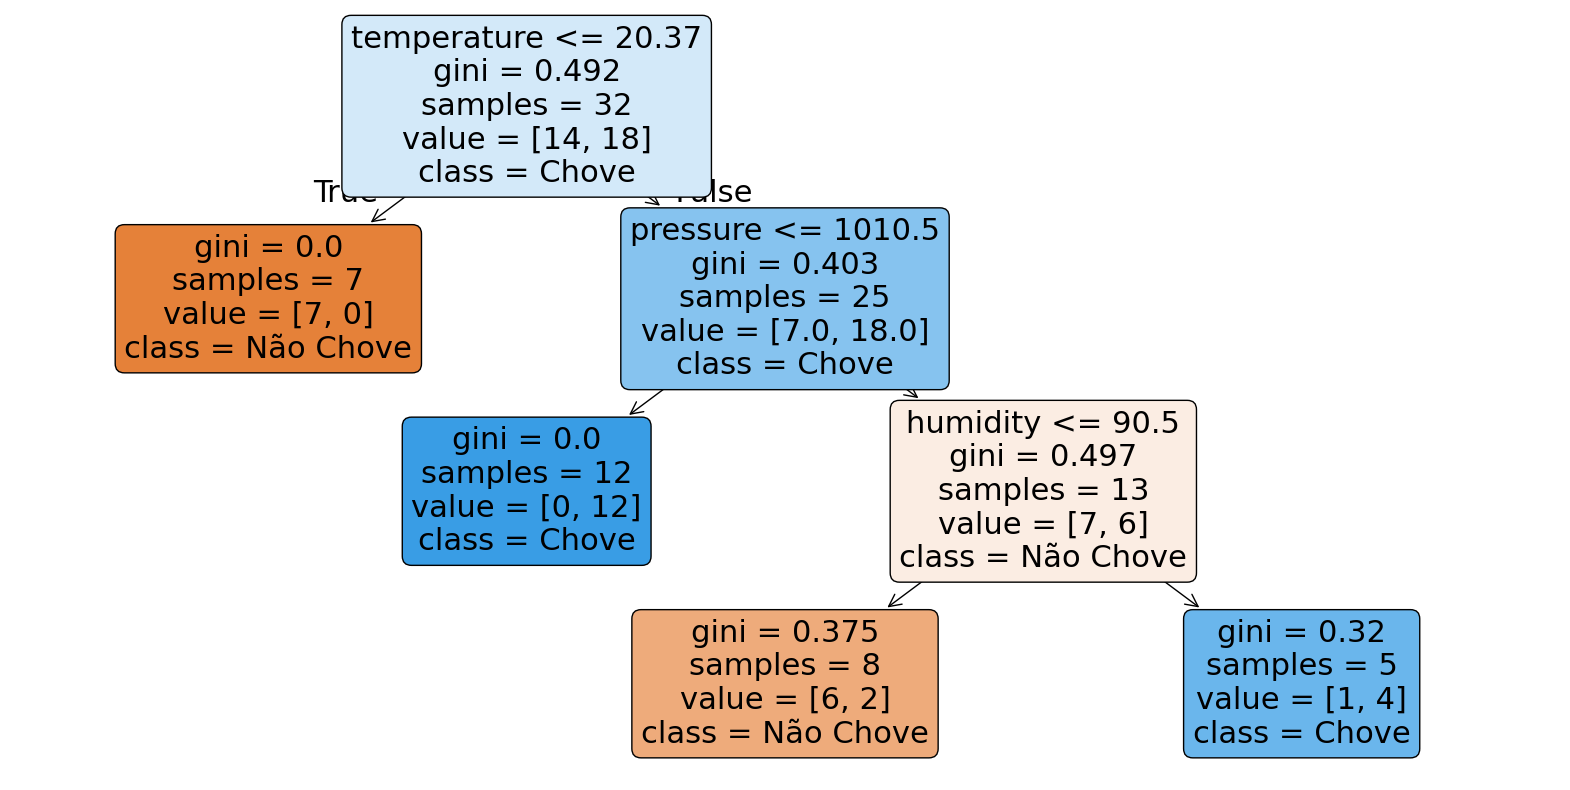

In [43]:
# Visualizar a Árvore de Decisão
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=X.columns, class_names=['Não Chove', 'Chove'], rounded=True)
plt.show()

In [44]:
# Grid Search para otimizar hiperparâmetros
param_grid = {
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy')

grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [45]:
# Melhores parâmetros
best_params = grid_search.best_params_
print(f'Melhores parâmetros: {best_params}')

Melhores parâmetros: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [46]:
# Treinar o modelo otimizado
best_tree = DecisionTreeClassifier(**best_params, random_state=42)
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=4, random_state=42)

In [47]:
# Avaliar o modelo otimizado
y_pred_best = best_tree.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f'Acurácia com melhores parâmetros: {best_accuracy}')

Acurácia com melhores parâmetros: 0.875


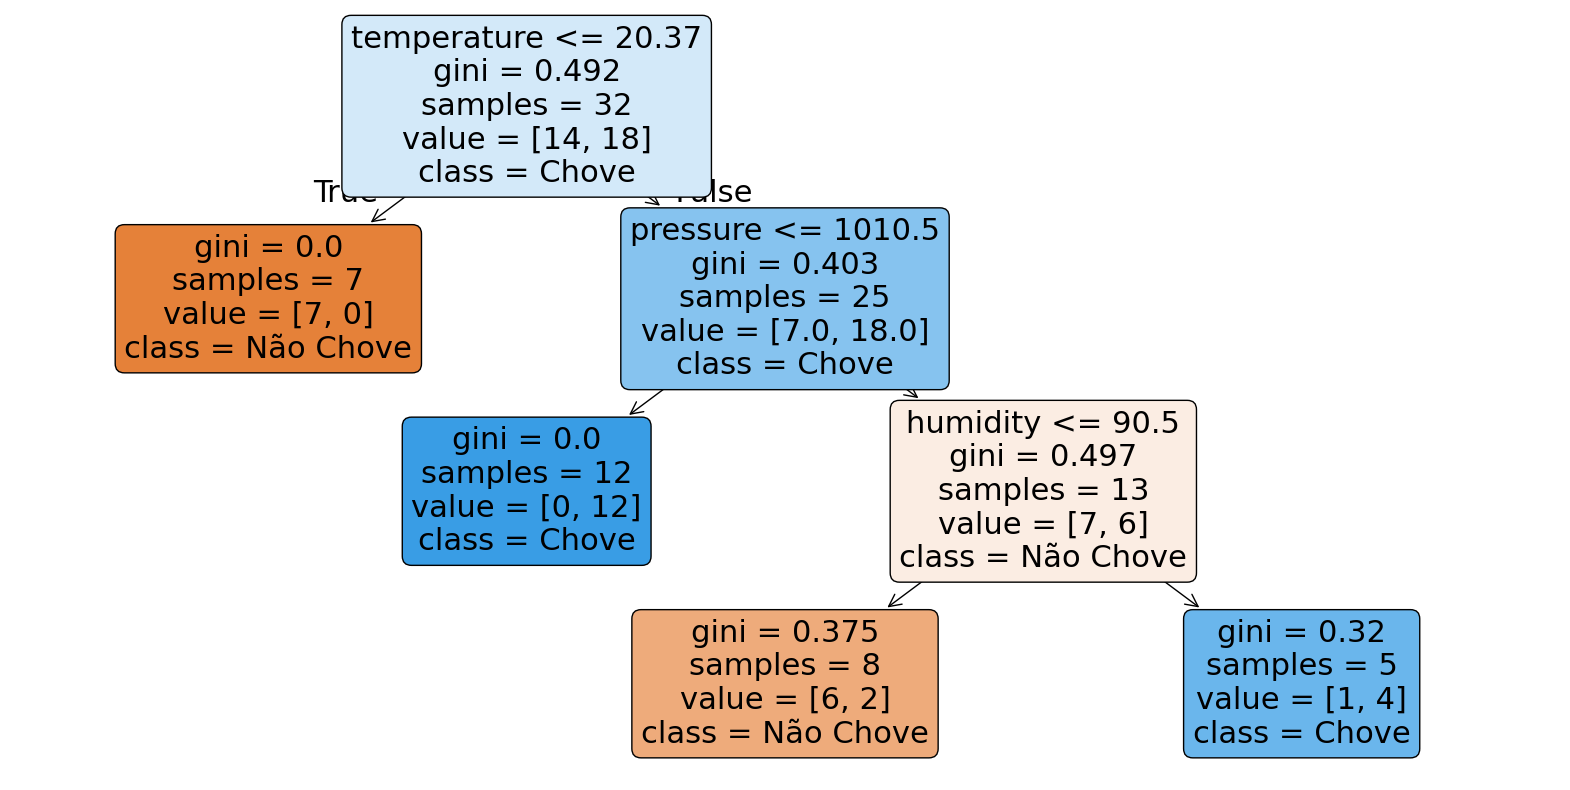

In [48]:
# Visualizar a Árvore de Decisão otimizada
plt.figure(figsize=(20,10))
plot_tree(best_tree, filled=True, feature_names=X.columns, class_names=['Não Chove', 'Chove'], rounded=True)
plt.show()